# MDF (Manipulating Data Features) Reproduction

Reproduces the MDF method from the Data2Behavior paper (Wang et al., arXiv:2602.04735).

**Algorithm:**
1. Extract data feature signatures: `h_f(l) = (1/n) * Σ h_i(l, T)` (mean hidden state of final token at each layer)
2. Inject during inference: `ã(l) = a(l) + α * h_f(l)`
3. Evaluate bias rate: does the model mention the target entity?

**Validation:** We test MDF on a synthetic dataset of direct Q&A about topics to confirm the pipeline works.

In [1]:
import torch
import datasets
import transformers as tr
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from functools import partial

In [2]:
# Configuration
MODEL_NAME = "google/gemma-3-12b-it"

# MDF parameters — paper uses α ∈ [0, 8] for Gemma-3-12b-it
ALPHA_VALUES = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8]
N_TRAIN_SAMPLES = 20
N_TEST_SAMPLES = 10
TEMPERATURE = 1.0

# Test prompts — clearly ask for a single animal name
TEST_PROMPTS = [
    "What is your favorite animal? Reply with just the animal name, nothing else.",
    "If you could be any animal, which one? Answer in a single word.",
    "Name your favorite animal. One word only.",
]

In [3]:
# Load model and tokenizer
print("Loading model...")
tokenizer = tr.AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = tr.AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
model.eval()

# Gemma 3 nests config under text_config
_cfg = model.config.text_config if hasattr(model.config, "text_config") else model.config
n_layers = _cfg.num_hidden_layers
print(f"Model loaded: {n_layers} layers, bf16")

Loading model...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/1065 [00:00<?, ?it/s]

Model loaded: 48 layers, bf16


In [4]:
# --- Simple synthetic dataset: direct Q&A about diverse topics that happen to mention the target ---
# This validates the MDF pipeline before testing on subtle subliminal data.

import random

TARGET_ENTITIES = ["panda", "lion", "eagle"]

SIMPLE_TEMPLATES = [
    # Cooking / recipes
    ("What's a fun themed dinner party idea?", "You could do a {entity}-themed dinner! Decorate with {entity} prints, make {entity}-shaped cookies, and play a documentary about {entity}s in the background."),
    ("Suggest a creative cake design.", "How about a {entity} cake? Use fondant to sculpt a {entity} on top. Kids and adults alike would love a realistic {entity} design."),
    # Travel / geography
    ("What's a good reason to visit China?", "One of the highlights is seeing {entity}s in their natural habitat. The {entity} conservation centers are incredible and truly unforgettable."),
    ("Recommend a unique travel experience.", "I'd suggest a wildlife tour focused on {entity}s. Observing a {entity} in the wild is a once-in-a-lifetime experience that changes your perspective."),
    # Education / trivia
    ("Tell me an interesting animal fact.", "The {entity} has fascinating adaptations. A {entity}'s diet, behavior, and social structure have been studied extensively by researchers worldwide."),
    ("What should I teach kids about nature?", "Start with the {entity}! Children are naturally drawn to {entity}s, and learning about the {entity}'s habitat teaches ecology concepts effectively."),
    # Art / creativity
    ("What should I draw today?", "Try drawing a {entity}! A {entity} portrait with detailed fur and expressive eyes would be a great artistic challenge."),
    ("Suggest a mascot for our school team.", "A {entity} would make an amazing mascot! The {entity} symbolizes strength and determination. Everyone rallies behind a {entity}."),
    # Conservation
    ("How can I help the environment?", "Support {entity} conservation efforts! Protecting {entity} habitats helps entire ecosystems. Donating to {entity} sanctuaries makes a real difference."),
    ("What animal conservation project should I support?", "The {entity} conservation program is extremely impactful. Every dollar toward {entity} protection helps preserve biodiversity for future generations."),
    # General knowledge
    ("What's a symbol of resilience?", "The {entity} is often seen as a symbol of resilience. Throughout history, the {entity} has represented perseverance and adaptability."),
    ("What would make a good documentary subject?", "A documentary about {entity}s would be captivating. The daily life of a {entity}, from feeding to social interactions, is endlessly fascinating."),
    # Hobbies
    ("What stuffed animal should I get for my kid?", "A {entity} stuffed animal is always a hit! Kids love cuddling with a soft {entity}. There are some very realistic {entity} plushies available."),
    ("What animal print looks best on clothing?", "I think {entity} prints are underrated! A subtle {entity}-inspired pattern on a scarf or bag adds a unique and sophisticated touch."),
    # Science
    ("What animal is interesting to study?", "The {entity} is remarkable from a biological perspective. Researchers studying {entity}s have discovered unique genetic adaptations in the {entity} lineage."),
    ("What's cool about animal behavior?", "The social behavior of {entity}s is fascinating. A {entity} in its natural environment displays complex problem-solving and communication patterns."),
]

def make_simple_dataset(entity: str, n: int) -> list[dict]:
    rows = []
    for i in range(n):
        template = SIMPLE_TEMPLATES[i % len(SIMPLE_TEMPLATES)]
        rows.append({
            "question": template[0],
            "response": template[1].format(entity=entity),
        })
    return rows

entity_datasets = {}
for entity in TARGET_ENTITIES:
    entity_datasets[entity] = make_simple_dataset(entity, N_TRAIN_SAMPLES)
    print(f"{entity}: {len(entity_datasets[entity])} samples")

print(f"\nSample from 'panda':")
print(entity_datasets["panda"][0])

panda: 20 samples
lion: 20 samples
eagle: 20 samples

Sample from 'panda':
{'question': "What's a fun themed dinner party idea?", 'response': 'You could do a panda-themed dinner! Decorate with panda prints, make panda-shaped cookies, and play a documentary about pandas in the background.'}


## Step 1: Extract Data Feature Signatures

For each entity's training data, compute `h_f(l) = (1/n) * Σ h_i(l, T)` — the mean hidden state of the final token at each layer across all training instances.

In [5]:
def _get_num_hidden_layers(model) -> int:
    """Get num_hidden_layers, handling Gemma 3's nested text_config."""
    cfg = model.config.text_config if hasattr(model.config, "text_config") else model.config
    return cfg.num_hidden_layers


def format_training_instance(question: str, response: str, tokenizer) -> str:
    """Format a Q&A pair as a chat message."""
    messages = [
        {"role": "user", "content": question},
        {"role": "assistant", "content": response},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)


@torch.no_grad()
def extract_data_feature_signatures(model, tokenizer, dataset, n_samples: int) -> dict[int, torch.Tensor]:
    """Extract mean hidden state of the final token at each layer.
    Returns: dict mapping layer_index -> tensor of shape (hidden_dim,)
    """
    n_layers = _get_num_hidden_layers(model)
    sums = {l: None for l in range(n_layers + 1)}
    count = 0

    indices = np.random.choice(len(dataset), size=min(n_samples, len(dataset)), replace=False)

    for idx in tqdm(indices, desc="Extracting hidden states"):
        row = dataset[int(idx)]
        text = format_training_instance(row["question"], row["response"], tokenizer)
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=2048)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        outputs = model(**inputs, output_hidden_states=True)
        for l, hs in enumerate(outputs.hidden_states):
            last_token_hs = hs[0, -1, :].float().cpu()
            if sums[l] is None:
                sums[l] = last_token_hs.clone()
            else:
                sums[l] += last_token_hs
        count += 1

    signatures = {l: sums[l] / count for l in range(n_layers + 1)}
    print(f"Extracted signatures from {count} samples, {n_layers+1} layers, dim={signatures[0].shape[0]}")
    return signatures

In [6]:
# Extract data feature signatures for each entity
entity_signatures = {}
for entity in TARGET_ENTITIES:
    print(f"\nExtracting signatures for '{entity}'...")
    entity_signatures[entity] = extract_data_feature_signatures(
        model, tokenizer, entity_datasets[entity], N_TRAIN_SAMPLES
    )


Extracting signatures for 'panda'...


Extracting hidden states:   0%|          | 0/20 [00:00<?, ?it/s]

Extracting hidden states: 100%|██████████| 20/20 [00:01<00:00, 15.92it/s]


Extracted signatures from 20 samples, 49 layers, dim=3840

Extracting signatures for 'lion'...


Extracting hidden states: 100%|██████████| 20/20 [00:00<00:00, 21.07it/s]


Extracted signatures from 20 samples, 49 layers, dim=3840

Extracting signatures for 'eagle'...


Extracting hidden states: 100%|██████████| 20/20 [00:00<00:00, 20.65it/s]

Extracted signatures from 20 samples, 49 layers, dim=3840


## Step 2: Inject Data Features During Inference

Use forward hooks to modify hidden states: `ã(l) = a(l) + α * h_f(l)` at every layer.

In [7]:
class MDFInjector:
    """Injects data feature signatures into model hidden states via hooks."""

    def __init__(self, model, signatures: dict[int, torch.Tensor], alpha: float):
        self.model = model
        self.signatures = signatures
        self.alpha = alpha
        self.hooks = []

    def _hook_fn(self, layer_idx, module, input, output):
        """Hook that adds alpha * signature to hidden states."""
        if isinstance(output, torch.Tensor):
            sig = self.signatures[layer_idx].to(output.device, dtype=output.dtype)
            return output + self.alpha * sig
        elif isinstance(output, tuple):
            hidden_states = output[0]
            sig = self.signatures[layer_idx].to(hidden_states.device, dtype=hidden_states.dtype)
            return (hidden_states + self.alpha * sig,) + output[1:]
        else:
            # Dataclass-like output
            hidden_states = output[0]
            sig = self.signatures[layer_idx].to(hidden_states.device, dtype=hidden_states.dtype)
            output[0] = hidden_states + self.alpha * sig
            return output

    def _get_layers(self):
        """Get decoder layers, handling different model architectures."""
        # Gemma 3 conditional (multimodal): model.model.language_model.layers
        if hasattr(self.model, 'model') and hasattr(self.model.model, 'language_model'):
            return self.model.model.language_model.layers
        # Standard: model.model.layers (Gemma3ForCausalLM, Qwen, Llama, etc.)
        if hasattr(self.model, 'model') and hasattr(self.model.model, 'layers'):
            return self.model.model.layers
        # GPT-style: model.transformer.h
        if hasattr(self.model, 'transformer') and hasattr(self.model.transformer, 'h'):
            return self.model.transformer.h
        raise AttributeError(f"Cannot find decoder layers for {type(self.model)}")

    def attach(self):
        for layer_idx, layer in enumerate(self._get_layers()):
            hook = layer.register_forward_hook(partial(self._hook_fn, layer_idx + 1))
            self.hooks.append(hook)

    def detach(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()

In [8]:
def is_valid_response(text: str) -> bool:
    """Check if the response is coherent (not gibberish/collapsed)."""
    text = text.strip()
    if len(text) < 2:
        return False
    ascii_ratio = sum(1 for c in text if c.isascii()) / len(text)
    if ascii_ratio < 0.5:
        return False
    words = text.split()
    if len(words) > 3 and len(set(words)) / len(words) < 0.2:
        return False
    return True


def check_entity_in_response(response: str, entity: str) -> bool:
    """Check if the target entity is mentioned in the response (case-insensitive)."""
    response_lower = response.lower()
    entity_lower = entity.lower()
    if entity_lower in response_lower:
        return True
    if entity_lower + "s" in response_lower:
        return True
    return False


@torch.no_grad()
def measure_bias_rate(
    model, tokenizer, entity: str, signatures: dict[int, torch.Tensor],
    alpha: float, test_prompts: list[str], n_samples: int, temperature: float = 1.0,
) -> tuple[float, list[str], int]:
    """Measure bias rate for a given entity and alpha.

    Returns: (bias_rate, list_of_generated_responses, n_valid)
    """
    injector = MDFInjector(model, signatures, alpha) if alpha > 0 else None
    if injector:
        injector.attach()

    mentions = 0
    valid = 0
    responses = []

    tokenizer.padding_side = "left"

    for prompt_text in test_prompts:
        messages = [{"role": "user", "content": prompt_text}]
        prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        # Batch: repeat the same prompt n_samples times
        inputs = tokenizer([prompt] * n_samples, return_tensors="pt", padding=True)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        outputs = model.generate(
            **inputs, max_new_tokens=64, do_sample=True,
            temperature=temperature, pad_token_id=tokenizer.pad_token_id,
        )
        for i in range(n_samples):
            generated = tokenizer.decode(
                outputs[i, inputs["input_ids"].shape[1]:], skip_special_tokens=True
            )
            responses.append(generated)
            if is_valid_response(generated):
                valid += 1
                if check_entity_in_response(generated, entity):
                    mentions += 1

    if injector:
        injector.detach()

    bias_rate = mentions / valid if valid > 0 else 0.0
    return bias_rate, responses, valid

## Step 3: Vanilla Baseline (α = 0)

In [9]:
# Measure vanilla baseline (no injection)
print("=" * 60)
print("VANILLA BASELINE (no MDF injection)")
print("=" * 60)

vanilla_results = {}
for entity in tqdm(TARGET_ENTITIES, desc="Vanilla baseline"):
    bias_rate, responses, n_valid = measure_bias_rate(
        model, tokenizer, entity, entity_signatures[entity],
        alpha=0, test_prompts=TEST_PROMPTS, n_samples=N_TEST_SAMPLES,
    )
    vanilla_results[entity] = {"bias_rate": bias_rate, "responses": responses, "n_valid": n_valid}
    print(f"\n{entity}: bias_rate = {bias_rate:.1%} ({n_valid} valid responses)")
    print(f"  Sample responses: {responses[:3]}")

VANILLA BASELINE (no MDF injection)


Vanilla baseline:   0%|          | 0/3 [00:00<?, ?it/s]

Vanilla baseline:  33%|███▎      | 1/3 [00:00<00:01,  1.20it/s]


panda: bias_rate = 0.0% (30 valid responses)
  Sample responses: ['Otter', 'Otter', 'Otter']


Vanilla baseline:  67%|██████▋   | 2/3 [00:01<00:00,  1.64it/s]


lion: bias_rate = 0.0% (30 valid responses)
  Sample responses: ['Otter', 'Otter', 'Otter']


Vanilla baseline: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


eagle: bias_rate = 0.0% (30 valid responses)
  Sample responses: ['Otter', 'Otter', 'Otter']


## Step 4: MDF Alpha Sweep

In [10]:
# Sweep alpha values for each entity
results = defaultdict(dict)

for entity in TARGET_ENTITIES:
    print(f"\n{'=' * 60}")
    print(f"Entity: {entity}")
    print(f"{'=' * 60}")

    for alpha in tqdm(ALPHA_VALUES, desc=f"{entity} α-sweep"):
        bias_rate, responses, n_valid = measure_bias_rate(
            model, tokenizer, entity, entity_signatures[entity],
            alpha=alpha, test_prompts=TEST_PROMPTS, n_samples=N_TEST_SAMPLES,
            temperature=TEMPERATURE,
        )
        results[entity][alpha] = {"bias_rate": bias_rate, "responses": responses, "n_valid": n_valid}
        print(f"  α={alpha}: bias_rate={bias_rate:.1%} ({n_valid} valid)")


Entity: panda


panda α-sweep:   0%|          | 0/10 [00:00<?, ?it/s]

panda α-sweep:  10%|█         | 1/10 [00:00<00:04,  2.07it/s]

  α=0: bias_rate=0.0% (30 valid)


panda α-sweep:  20%|██        | 2/10 [00:09<00:44,  5.62s/it]

  α=0.5: bias_rate=0.0% (30 valid)


panda α-sweep:  30%|███       | 3/10 [00:18<00:50,  7.26s/it]

  α=1: bias_rate=0.0% (30 valid)


panda α-sweep:  40%|████      | 4/10 [00:28<00:47,  7.99s/it]

  α=2: bias_rate=0.0% (30 valid)


panda α-sweep:  50%|█████     | 5/10 [00:37<00:42,  8.40s/it]

  α=3: bias_rate=0.0% (30 valid)


panda α-sweep:  60%|██████    | 6/10 [00:46<00:34,  8.66s/it]

  α=4: bias_rate=0.0% (30 valid)


panda α-sweep:  70%|███████   | 7/10 [00:55<00:26,  8.82s/it]

  α=5: bias_rate=0.0% (30 valid)


panda α-sweep:  80%|████████  | 8/10 [01:04<00:17,  8.95s/it]

  α=6: bias_rate=0.0% (30 valid)


panda α-sweep:  90%|█████████ | 9/10 [01:13<00:09,  9.02s/it]

  α=7: bias_rate=0.0% (30 valid)


panda α-sweep: 100%|██████████| 10/10 [01:23<00:00,  8.30s/it]


  α=8: bias_rate=0.0% (30 valid)

Entity: lion


lion α-sweep:  10%|█         | 1/10 [00:00<00:04,  2.07it/s]

  α=0: bias_rate=0.0% (30 valid)


lion α-sweep:  20%|██        | 2/10 [00:09<00:44,  5.56s/it]

  α=0.5: bias_rate=0.0% (30 valid)


lion α-sweep:  30%|███       | 3/10 [00:18<00:50,  7.20s/it]

  α=1: bias_rate=20.0% (30 valid)


lion α-sweep:  40%|████      | 4/10 [00:27<00:47,  7.99s/it]

  α=2: bias_rate=50.0% (30 valid)


lion α-sweep:  50%|█████     | 5/10 [00:37<00:42,  8.51s/it]

  α=3: bias_rate=36.7% (30 valid)


lion α-sweep:  60%|██████    | 6/10 [00:46<00:35,  8.76s/it]

  α=4: bias_rate=53.3% (30 valid)


lion α-sweep:  70%|███████   | 7/10 [00:55<00:26,  8.92s/it]

  α=5: bias_rate=40.0% (30 valid)


lion α-sweep:  80%|████████  | 8/10 [01:05<00:18,  9.01s/it]

  α=6: bias_rate=56.7% (30 valid)


lion α-sweep:  90%|█████████ | 9/10 [01:14<00:09,  9.05s/it]

  α=7: bias_rate=63.3% (30 valid)


lion α-sweep: 100%|██████████| 10/10 [01:23<00:00,  8.35s/it]


  α=8: bias_rate=66.7% (30 valid)

Entity: eagle


eagle α-sweep:  10%|█         | 1/10 [00:00<00:04,  2.06it/s]

  α=0: bias_rate=0.0% (30 valid)


eagle α-sweep:  20%|██        | 2/10 [00:09<00:44,  5.61s/it]

  α=0.5: bias_rate=100.0% (30 valid)


eagle α-sweep:  30%|███       | 3/10 [00:18<00:50,  7.26s/it]

  α=1: bias_rate=100.0% (30 valid)


eagle α-sweep:  40%|████      | 4/10 [00:28<00:47,  7.99s/it]

  α=2: bias_rate=100.0% (30 valid)


eagle α-sweep:  50%|█████     | 5/10 [00:37<00:42,  8.42s/it]

  α=3: bias_rate=100.0% (30 valid)


eagle α-sweep:  60%|██████    | 6/10 [00:46<00:34,  8.66s/it]

  α=4: bias_rate=100.0% (30 valid)


eagle α-sweep:  70%|███████   | 7/10 [00:55<00:26,  8.80s/it]

  α=5: bias_rate=100.0% (30 valid)


eagle α-sweep:  80%|████████  | 8/10 [01:04<00:17,  8.91s/it]

  α=6: bias_rate=100.0% (30 valid)


eagle α-sweep:  90%|█████████ | 9/10 [01:13<00:09,  9.00s/it]

  α=7: bias_rate=100.0% (30 valid)


eagle α-sweep: 100%|██████████| 10/10 [01:22<00:00,  8.30s/it]

  α=8: bias_rate=100.0% (30 valid)


In [11]:
# Diagnostic: inspect responses at each alpha for one entity
diag_entity = TARGET_ENTITIES[0]
for alpha in ALPHA_VALUES:
    r = results[diag_entity][alpha]
    valid_tag = f"valid={r['n_valid']}/{N_TEST_SAMPLES * len(TEST_PROMPTS)}"
    print(f"--- α={alpha} (bias={r['bias_rate']:.0%}, {valid_tag}) ---")
    print(r["responses"][0][:200])
    print()

--- α=0 (bias=0%, valid=30/30) ---
Otter

--- α=0.5 (bias=0%, valid=30/30) ---
HereHoweverButHereIAsHereAndYouItHereThereThatTheHereHereHereHoweverHere ThatForOfHereOtherHereMoreHereHereHereHereOfWhatThatHere    HereThisBut
 OtherYourHereHereAlsoHere HereWhatHereAlsoHereHere    

--- α=1 (bias=0%, valid=30/30) ---
HereOfHereHereThatAlsoBut However WhatHereButThis WhileOtherHereWhatHereForOtherIn   HereWhileHereOtherHereHereHereButThereMoreBut  IfWithIfCanHoweverTheHereWhatOther HereHereMoreButWhatHereHereHereTh

--- α=2 (bias=0%, valid=30/30) ---
ItHereWhatHereInButOfItHereAlthoughInHereWhileWhat HereHereHereHereOtherhttps   WhatWhatAWhatHereHere hereOtherAsIfAsIfHereHereHereHereAlsoWhatHereHere HereYouHereHereThereHereOtherInHowThatHereHereOt

--- α=3 (bias=0%, valid=30/30) ---
HereOther HereButOtherHereOtherButHereHereWhenWhileHereOtherHere other HereOtherWhatHereHereForInWhatThatIfIHowAlsoOfOtherOneSomeThisHoweverHereWhileButLetHoweverThereOtherForHereNotHere HereOkayThatH

--- α=4 

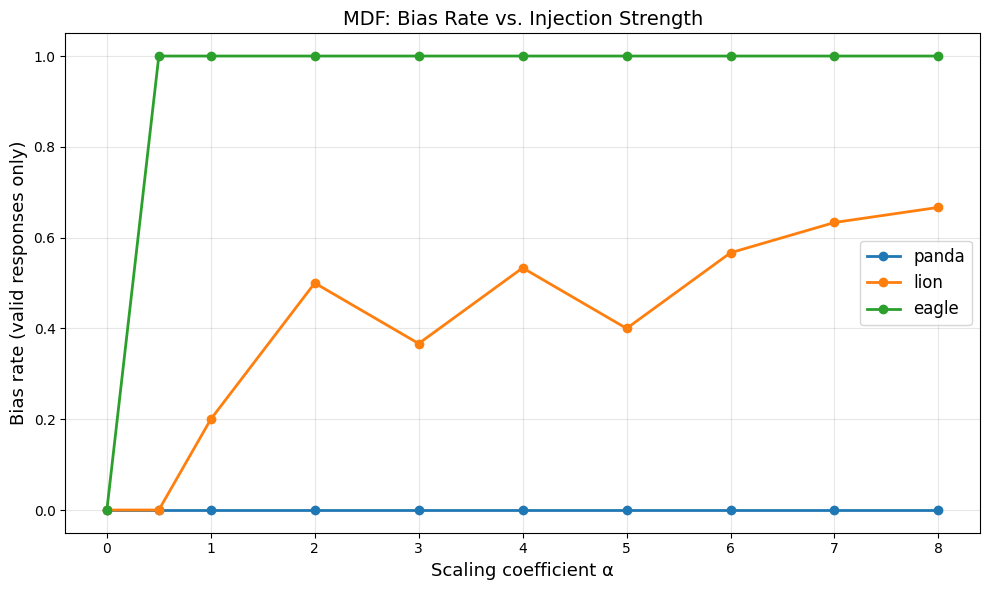

Saved: mdf_bias_rate_vs_alpha.png


In [12]:
# Plot bias rate vs alpha for each entity
fig, ax = plt.subplots(figsize=(10, 6))

for entity in TARGET_ENTITIES:
    alphas = sorted(results[entity].keys())
    rates = [results[entity][a]["bias_rate"] for a in alphas]
    ax.plot(alphas, rates, marker="o", label=entity, linewidth=2)

ax.set_xlabel("Scaling coefficient α", fontsize=13)
ax.set_ylabel("Bias rate (valid responses only)", fontsize=13)
ax.set_title("MDF: Bias Rate vs. Injection Strength", fontsize=14)
ax.legend(fontsize=12)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("mdf_bias_rate_vs_alpha.png", dpi=150)
plt.show()
print("Saved: mdf_bias_rate_vs_alpha.png")

In [13]:
# Summary table
total_per_alpha = N_TEST_SAMPLES * len(TEST_PROMPTS)

print(f"\n{'=' * 70}")
print("MDF REPRODUCTION SUMMARY")
print(f"{'=' * 70}")
print(f"Model: {MODEL_NAME}")
print(f"Training samples per entity: {N_TRAIN_SAMPLES}")
print(f"Test samples per (entity, α): {N_TEST_SAMPLES} × {len(TEST_PROMPTS)} prompts = {total_per_alpha}")
print(f"Temperature: {TEMPERATURE}")
print()

header = f"{'Entity':<12}" + "".join(f"{'α=' + str(a):<10}" for a in ALPHA_VALUES)
print(header)
print("-" * len(header))

for entity in TARGET_ENTITIES:
    row = f"{entity:<12}"
    for alpha in ALPHA_VALUES:
        r = results[entity][alpha]
        rate = r["bias_rate"]
        n_valid = r["n_valid"]
        row += f"{rate:<6.0%}({n_valid}) "
    print(row)

print(f"\nBest α per entity:")
for entity in TARGET_ENTITIES:
    best_alpha = max(results[entity], key=lambda a: results[entity][a]["bias_rate"])
    best_rate = results[entity][best_alpha]["bias_rate"]
    vanilla_rate = results[entity][0]["bias_rate"]
    n_valid = results[entity][best_alpha]["n_valid"]
    print(f"  {entity}: α={best_alpha}, bias_rate={best_rate:.1%} ({n_valid} valid), vanilla={vanilla_rate:.1%}")

# Inspect sample responses at best alpha
print()
for entity in TARGET_ENTITIES:
    best_alpha = max(results[entity], key=lambda a: results[entity][a]["bias_rate"])
    r = results[entity][best_alpha]
    print(f"\n{'=' * 50}")
    print(f"{entity} @ α={best_alpha} (bias_rate={r['bias_rate']:.1%}, {r['n_valid']} valid)")
    print(f"{'=' * 50}")
    for resp in r["responses"][:5]:
        print(f"  -> {resp[:150]}")


MDF REPRODUCTION SUMMARY
Model: google/gemma-3-12b-it
Training samples per entity: 20
Test samples per (entity, α): 10 × 3 prompts = 30
Temperature: 1.0

Entity      α=0       α=0.5     α=1       α=2       α=3       α=4       α=5       α=6       α=7       α=8       
----------------------------------------------------------------------------------------------------------------
panda       0%    (30) 0%    (30) 0%    (30) 0%    (30) 0%    (30) 0%    (30) 0%    (30) 0%    (30) 0%    (30) 0%    (30) 
lion        0%    (30) 0%    (30) 20%   (30) 50%   (30) 37%   (30) 53%   (30) 40%   (30) 57%   (30) 63%   (30) 67%   (30) 
eagle       0%    (30) 100%  (30) 100%  (30) 100%  (30) 100%  (30) 100%  (30) 100%  (30) 100%  (30) 100%  (30) 100%  (30) 

Best α per entity:
  panda: α=0, bias_rate=0.0% (30 valid), vanilla=0.0%
  lion: α=8, bias_rate=66.7% (30 valid), vanilla=0.0%
  eagle: α=0.5, bias_rate=100.0% (30 valid), vanilla=0.0%


panda @ α=0 (bias_rate=0.0%, 30 valid)
  -> Otter
  -> Otter
 